# SWOP script 5 - Linear Mixed Effects Analysis
## 300-500 ms time window

This script imports a CSV file generated by the script *SWOP 4 - Measure ERPS* and performs linear mixed effects modelling.

Following general best practices, we are using **individual trial** data. Note that outliers (defined as data points at the level of subjets/trials/channels with abs(*z*) > 2.5) have been removed in script 4. 

A few technical notes:
- while LME is most commonly run using the *lmer()* function in the *lme4* package, we instead use the *bam()* function in the *mgcv* package. While mgcv/bam is written for generalized additive modelling, it allows for LME by using the *bs='re'* flag for smooths (where  're' stands for 'random effects'). The *bam()* function is parallelized, as well as being well-optimized, making it much faster to run, and without convergence errors that sometimes plague *lmer()* models
- best practices  in LME modelling tend to encourage full random effects models, and also by-item random effects and even random slopes for items within subjects. However, these models quickly become computationally very expensive, both in terms of time and RAM required. They are computed  here, but it is impossible to generate the tables of results and effet sizes with *emmeans()*, nor plot the contrasts of interest. My past experience, as well as experience with this dataset, is that these more elaborate random effects models do generate much smaller AIC values, and higher explained variance of the models. However, they do not in any appreciable way impact the general pattern of results (in terms of what's significant in the ANOVA tables, nor the effect sizes of our contrasts of interest). For these reasons, the models we ultimately present are not the "best" in the sense of AIC values or explained variance, but they tell efefctively the same story. For reference, however, the more complex models are computed and summarized here for reference. 

---
Copyright 2016-21  [Aaron J Newman](https://github.com/aaronjnewman), [NeuroCognitive Imaging Lab](http://ncil.science), [Dalhousie University](https://dal.ca)

Released under the [BSD 3-clause license](https://opensource.org/licenses/BSD-3-Clause)

---

## Load necessary libraries

In [50]:
date()

[1] "Sat Aug 28 17:00:46 2021"

In [51]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(mgcv)
library(parallel)
# library(viridis)
library(emmeans)
library(sjPlot)

## Set parameters for this analysis

In [84]:
component = '300-500'
expt = 'SWOP'
data_path = '../group_data/'

data_file = paste(data_path, 'SWOP_ERP_measurements.csv', sep="")

# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores = 14

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

## Load Data

In [53]:
dat <- read.csv(data_file,
               colClasses=c('factor', 'numeric', 'factor', 
                            'factor', 'factor', 'factor', 
                            'factor',  'factor', 'factor', 
                            'numeric', 'factor', 'factor',
                            'factor', 'factor', 'factor', 
                            'factor', 'numeric', 'factor',
                            'numeric'
                           )
               )

dat$ROI <- factor(dat$ROI, levels=c('L_Ant', 'M_Ant', 'R_Ant',
                                       'L_Cent', 'M_Cent', 'R_Cent',
                                       'L_Post', 'M_Post', 'R_Post'
                                      ))

# specify ordering of condtiions, for plots and contrats
dat$Adverb <- factor(dat$Adverb, levels=c('kanske', 'hemma', 'idag'))
# Force contrasts as V3-V2
dat$SentPos <- factor(dat$SentPos, levels=c('V3', 'V2'))

### Select only data for ERP component of interest

In [54]:
dat <- subset(dat, Component==component | Component=='baseline')
dat <- droplevels(dat)

### Remove missing data 

In [55]:
dat <- dat[complete.cases(dat), ]

## Summary/Descriptives

In [56]:
summary(dat)

    Subject        Trial.Time          Condition          ROI       
 s_04nm : 6404   Min.   :   1157   V2/hemma :21018   L_Post :18909  
 s_18ak : 6335   1st Qu.: 499375   V2/idag  :20908   L_Cent :18877  
 s_19am : 6330   Median :1068687   V2/kanske:20957   R_Cent :18823  
 s_13ff : 6329   Mean   :1096223   V3/hemma :21086   R_Post :18796  
 s_21ma : 6327   3rd Qu.:1654384   V3/idag  :21011   R_Ant  :18729  
 s_26nm : 6324   Max.   :2977152   V3/kanske:21055   L_Ant  :18689  
 (Other):87986                                       (Other):13212  
    Channel         Sentence      postphrase  pronoun_noun questiondisplay.ACC
 TP8    : 4793   243    :   540   0.0:21006   N:63074      0: 20219           
 P7     : 4789   152    :   539   1.0:23121   P:62961      1:105816           
 TP7    : 4786   256    :   539   2.0:17379                                   
 T8     : 4779   409    :   539   3.0:25077                                   
 P8     : 4778   112    :   538   4.0:22445          

In [57]:
str(dat)

'data.frame':	126035 obs. of  19 variables:
 $ Subject            : Factor w/ 20 levels "s_04nm","s_07ba",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Trial.Time         : num  34102 34102 34102 34102 34102 ...
 $ Condition          : Factor w/ 6 levels "V2/hemma","V2/idag",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ROI                : Factor w/ 9 levels "L_Ant","M_Ant",..: 1 1 1 1 4 4 4 4 7 7 ...
 $ Channel            : Factor w/ 27 levels "C3","C4","CP3",..: 6 8 10 12 1 3 24 26 15 17 ...
 $ Sentence           : Factor w/ 240 levels "10","101","102",..: 215 215 215 215 215 215 215 215 215 215 ...
 $ postphrase         : Factor w/ 6 levels "0.0","1.0","2.0",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ pronoun_noun       : Factor w/ 2 levels "N","P": 1 1 1 1 1 1 1 1 1 1 ...
 $ questiondisplay.ACC: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ questiondisplay.RT : num  213 213 213 213 213 213 213 213 213 213 ...
 $ sentence_no        : Factor w/ 40 levels "1.0","10.0","11.0",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ s

## Get counts of trials in each cell of design
We select data from Cz just to avoid repeated measures for all the electrodes

In [58]:
crosstab <- xtabs(~ SentPos + Adverb, data=subset(dat, Component==component & Channel=='Cz'))
ftable(crosstab) # print table 
summary(crosstab) #

        Adverb kanske hemma idag
SentPos                         
V3                724   724  733
V2                711   723  710

Call: xtabs(formula = ~SentPos + Adverb, data = subset(dat, Component == 
    component & Channel == "Cz"))
Number of cases in table: 4325 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 0.169, df = 2, p-value = 0.92

### Visualize distributions

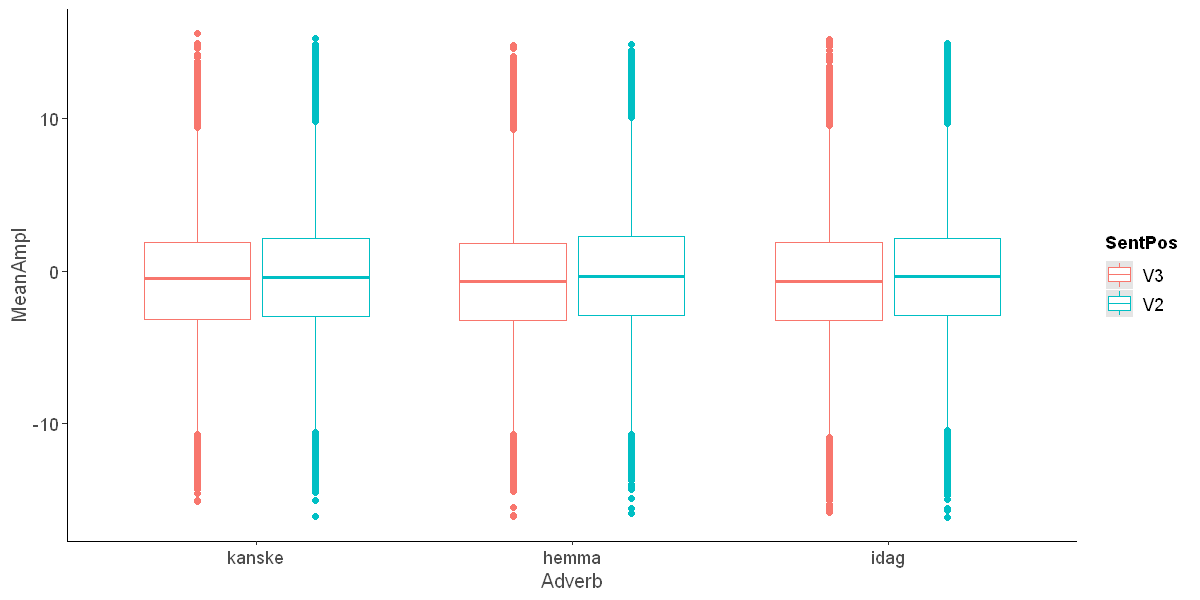

In [59]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(dat, aes(y=MeanAmpl, x=Adverb, col=SentPos)) + 
    geom_boxplot() 

## LME modelling

Note: we use the `bam()` function but fit linear models.

### Fit a simple-but-full model without baseline

In [60]:
cl <- makeCluster(num_cores)  

m0 <- bam(MeanAmpl ~ (Adverb * SentPos * ROI)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)


Method: fREML   Optimizer: perf newton
full convergence after 8 iterations.
Gradient range [-0.0000000023138,-0.0000000000000035527]
(score 355518 & scale 16.481).
Hessian positive definite, eigenvalue range [9.2999,62991].
Model rank =  74 / 74 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

             k'  edf k-index p-value
s(Subject) 20.0 18.8      NA      NA


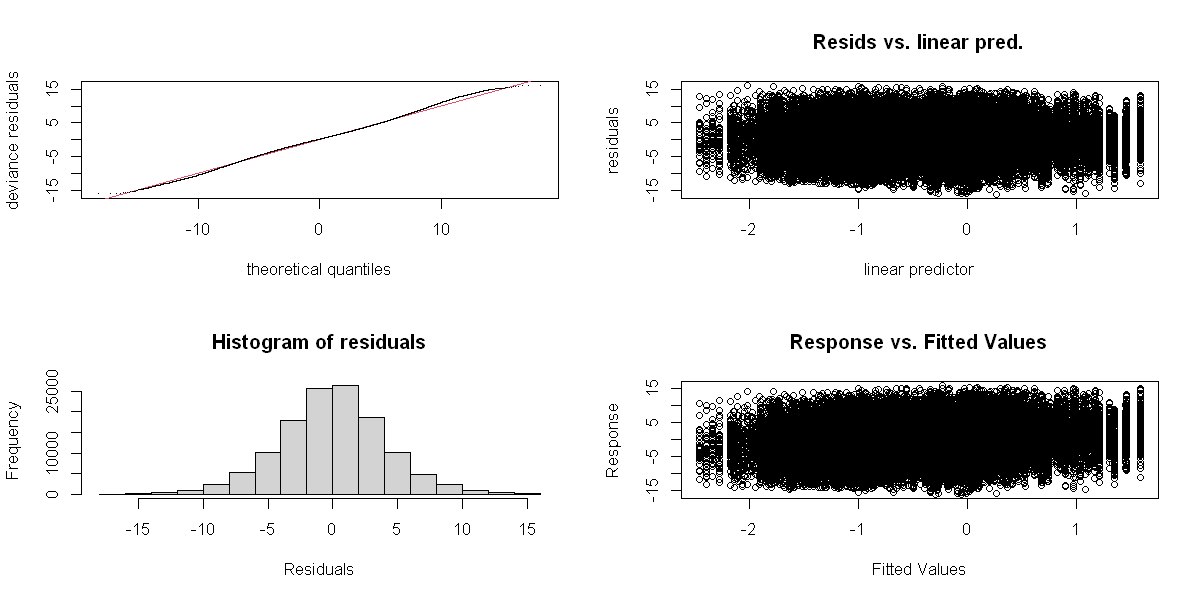

In [61]:
gam.check(m0)

In [62]:
anova(m0)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb * SentPos * ROI) + s(Subject, bs = "re")

Parametric Terms:
                   df     F              p-value
Adverb              2  0.37                0.694
SentPos             1  2.94                0.087
ROI                 8 19.07 < 0.0000000000000002
Adverb:SentPos      2  3.93                0.020
Adverb:ROI         16  0.57                0.911
SentPos:ROI         8 10.81   0.0000000000000024
Adverb:SentPos:ROI 16  1.24                0.230

Approximate significance of smooth terms:
            edf Ref.df    F             p-value
s(Subject) 18.8   19.0 94.1 <0.0000000000000002

## Include baseline as fixed effect, not interacting with other factors

In [63]:
cl <- makeCluster(num_cores)  

m_b_nox <- bam(MeanAmpl ~ (Adverb * SentPos * ROI) + baseline
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Include baseline as a fixed effect, *fully interacting* with other factors

In [64]:
cl <- makeCluster(num_cores)  

m_full <- bam(MeanAmpl ~ (Adverb * SentPos * ROI * baseline)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Add random intercepts for items (sentences) as well as subjects

In [65]:
cl <- makeCluster(num_cores)  

mf_4w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Allow only 3-way interactions

In [66]:
cl <- makeCluster(num_cores)  

mf_3w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 4 way interactions

This takes a long time to fit, and requires lots of RAM

In [67]:
cl <- makeCluster(num_cores)  

mf_4w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 3 way interactions

In [68]:
cl <- makeCluster(num_cores)  

mf_3w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Random intercepts by item, not nested in subjects

In [69]:
cl <- makeCluster(num_cores)  

mf_4w_reci <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Compare models

In [70]:
AICtab <- as.data.frame(AIC(m0, m_full, m_b_nox, 
                            mf_3w_rei, mf_3w_recsis,
                            mf_4w_rei, mf_4w_recsis, mf_4w_reci
                           )) 
AICtab$deltaAIC <-AICtab$AIC - min(AICtab$AIC)
AICtab[order(AICtab$AIC),]

,df,AIC,deltaAIC
,<dbl>,<dbl>,<dbl>
mf_4w_recsis,5219.527,620648,0.000
mf_3w_recsis,5203.521,620663,14.309
mf_4w_reci,816.270,703418,82769.827
mf_4w_rei,349.827,706415,85766.859
mf_3w_rei,333.821,706423,85774.376
m_full,127.828,709622,88973.532
m_b_nox,74.826,709731,89082.603
m0,73.822,710920,90271.382


---
## Explore best model

### Best Model

**`mf_4w_recsis`** has smallest AIC

However, the random effects structure is so complex that we can't generate plots of this model below (requires more RAM than we have; takes > 24 h to fit and then maybe crashes). For those we use the model **`mf_4w_reci`**, which is the same but with only random intercepts by sentence, not sentence-by-subject RE

The plotted effect sizes and confidence intervals do not change in any visually-detectable way between these models with different random effects structures anyway.

In [71]:
anova(mf_4w_recsis)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Channel, 
    Subject, bs = "re") + s(Sentence, Subject, bs = "re")

Parametric Terms:
                            df     F              p-value
Adverb                       2  0.23              0.79368
SentPos                      1  2.72              0.09891
ROI                          8 12.01 < 0.0000000000000002
baseline                     1 10.58              0.00114
Adverb:SentPos               2  1.37              0.25301
Adverb:ROI                  16  0.71              0.78542
Adverb:baseline              2  6.61              0.00134
SentPos:ROI                  8 17.55 < 0.0000000000000002
SentPos:baseline             1 30.22          0.000000039
ROI:baseline                 8  1.25              0.26585
Adverb:SentPos:ROI          16  1.74              0.03290
Adverb:SentPos:baseline      2 10.63          0.000024233
Adverb:ROI:baseline         16  1.93              0.

In [72]:
summary(mf_4w_recsis)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Channel, 
    Subject, bs = "re") + s(Sentence, Subject, bs = "re")

Parametric coefficients:
                                          Estimate Std. Error t value
(Intercept)                              -0.623587   0.140585   -4.44
Adverbhemma                              -0.068744   0.161809   -0.42
Adverbidag                               -0.108501   0.161467   -0.67
SentPosV2                                -0.267122   0.161876   -1.65
ROIM_Ant                                 -0.805242   0.216290   -3.72
ROIR_Ant                                 -0.195491   0.136412   -1.43
ROIL_Cent                                 0.192903   0.135783    1.42
ROIM_Cent                                -0.955931   0.217560   -4.39
ROIR_Cent                                -0.245787   0.136235   -1.80
ROIL_Post                                 0.547326   0.135869    4.03
ROIM_Post                    

### View the model that gives best AIC, within computational feasibility

In [73]:
mod = mf_4w_rei #mf_4w_rei

In [74]:
anova(mod)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Subject, 
    bs = "re") + s(Sentence, bs = "re")

Parametric Terms:
                            df     F              p-value
Adverb                       2  0.13              0.88049
SentPos                      1  5.41              0.02008
ROI                          8 21.94 < 0.0000000000000002
baseline                     1 14.21              0.00016
Adverb:SentPos               2  3.35              0.03523
Adverb:ROI                  16  0.59              0.89092
Adverb:baseline              2  1.82              0.16273
SentPos:ROI                  8  8.25       0.000000000031
SentPos:baseline             1  5.18              0.02290
ROI:baseline                 8  3.40              0.00066
Adverb:SentPos:ROI          16  0.84              0.64108
Adverb:SentPos:baseline      2  3.18              0.04162
Adverb:ROI:baseline         16  2.39              0.00140
SentPos:ROI:

In [75]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Subject, 
    bs = "re") + s(Sentence, bs = "re")

Parametric coefficients:
                                          Estimate Std. Error t value
(Intercept)                              -0.638032   0.152964   -4.17
Adverbhemma                              -0.030107   0.147180   -0.20
Adverbidag                               -0.073535   0.146549   -0.50
SentPosV2                                -0.239672   0.103087   -2.32
ROIM_Ant                                 -0.819198   0.164433   -4.98
ROIR_Ant                                 -0.181222   0.102916   -1.76
ROIL_Cent                                 0.207688   0.101241    2.05
ROIM_Cent                                -0.944139   0.167686   -5.63
ROIR_Cent                                -0.218822   0.102398   -2.14
ROIL_Post                                 0.577811   0.101371    5.70
ROIM_Post                                -0.620

## View results

In [76]:
contr <- emmeans(mod,  pairwise ~ SentPos | Adverb * ROI)

contr_tab = contr$contrasts %>% as.data.frame()
ncomp = nrow(contr_tab)
contr_tab$'p (raw)'   = round(contr_tab$'p.value', 4)
contr_tab$'p (FDR BH)' = round(p.adjust(contr_tab$'p.value', method = 'BH', n = ncomp), 4)
contr_tab <- subset(contr_tab, select=-c(p.value))
contr_tab

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



,contrast,Adverb,ROI,estimate,SE,df,t.ratio,p (raw),p (FDR BH)
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V3 - V2,kanske,L_Ant,0.187225,0.10135,125686,1.84729,0.0647,0.0971
2,V3 - V2,hemma,L_Ant,0.289171,0.10130,125686,2.85462,0.0043,0.0102
3,V3 - V2,idag,L_Ant,-0.055410,0.10161,125686,-0.54530,0.5855,0.6324
4,V3 - V2,kanske,M_Ant,-0.522309,0.20760,125686,-2.51597,0.0119,0.0214
5,V3 - V2,hemma,M_Ant,-0.355558,0.20858,125686,-1.70465,0.0883,0.1254
6,V3 - V2,idag,M_Ant,-0.439555,0.20920,125686,-2.10108,0.0356,0.0601
7,V3 - V2,kanske,R_Ant,0.155238,0.10139,125686,1.53113,0.1257,0.1697
8,V3 - V2,hemma,R_Ant,-0.035632,0.10134,125686,-0.35160,0.7251,0.7530
9,V3 - V2,idag,R_Ant,-0.072738,0.10176,125686,-0.71481,0.4747,0.5573


## Get effect sizes on differences 
Cohen's *d*

### Plot effect sizes for all V3-V2 contrasts

Also save a PDF version of the plot

Since 'object' is a list, we are using the contrasts already present.



png 
  2

Since 'object' is a list, we are using the contrasts already present.



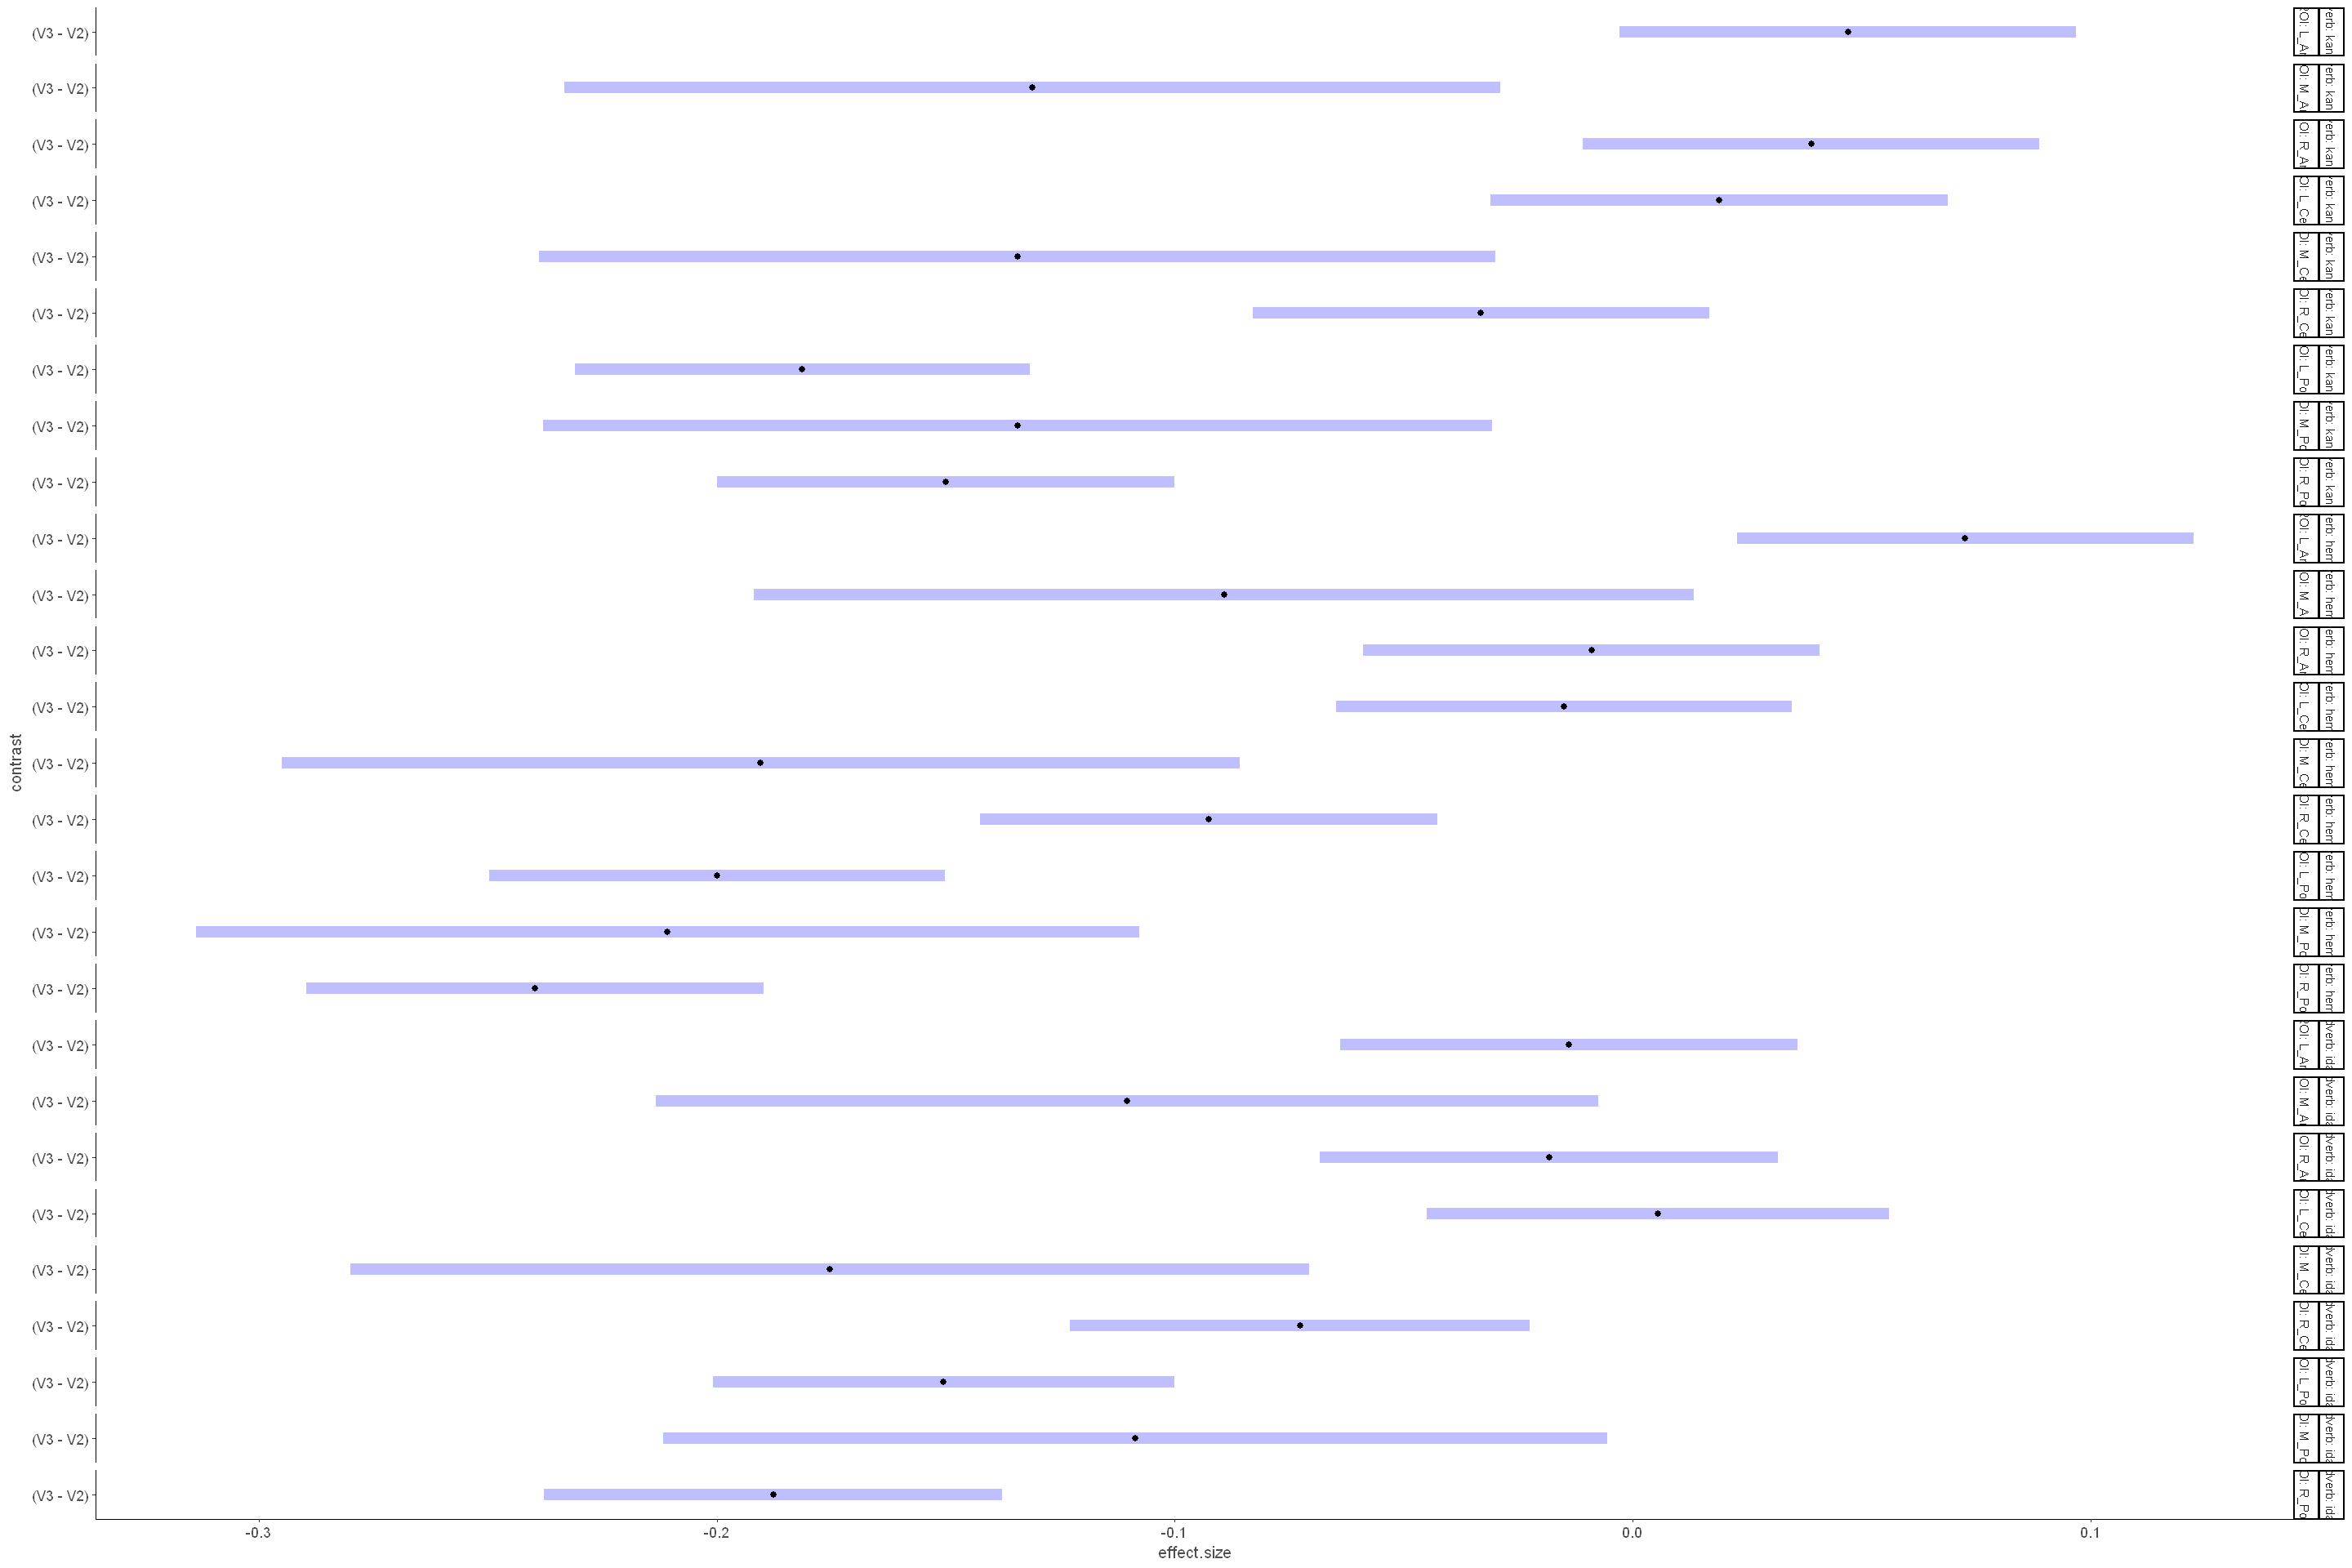

In [93]:
pdf(paste('../figures/', 'lme_effect_plot_', component, '.pdf', sep="")) 
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))
dev.off() 
options(repr.plot.width=24, repr.plot.height=16)
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))

In [78]:
eff_tab <- eff_size(contr, sigma = sigma(mod), edf = 125000) %>% as.data.frame()
full_tab <- contr_tab %>% full_join(eff_tab, by=c("ROI", 'Adverb'), suffix = c(".ctr", ".eff"))
full_tab

Since 'object' is a list, we are using the contrasts already present.



contrast.ctr,Adverb,ROI,estimate,SE.ctr,df.ctr,t.ratio,p (raw),p (FDR BH),contrast.eff,effect.size,SE.eff,df.eff,lower.CL,upper.CL
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V3 - V2,kanske,L_Ant,0.187225,0.10135,125686,1.84729,0.0647,0.0971,(V3 - V2),0.0469981,0.025442,125686,-0.0028673,0.0968635
V3 - V2,hemma,L_Ant,0.289171,0.10130,125686,2.85462,0.0043,0.0102,(V3 - V2),0.0725891,0.025429,125686,0.0227486,0.1224297
V3 - V2,idag,L_Ant,-0.055410,0.10161,125686,-0.54530,0.5855,0.6324,(V3 - V2),-0.0139093,0.025508,125686,-0.0639037,0.0360850
V3 - V2,kanske,M_Ant,-0.522309,0.20760,125686,-2.51597,0.0119,0.0214,(V3 - V2),-0.1311124,0.052113,125686,-0.2332525,-0.0289723
V3 - V2,hemma,M_Ant,-0.355558,0.20858,125686,-1.70465,0.0883,0.1254,(V3 - V2),-0.0892539,0.052359,125686,-0.1918772,0.0133694
V3 - V2,idag,M_Ant,-0.439555,0.20920,125686,-2.10108,0.0356,0.0601,(V3 - V2),-0.1103390,0.052516,125686,-0.2132692,-0.0074088
V3 - V2,kanske,R_Ant,0.155238,0.10139,125686,1.53113,0.1257,0.1697,(V3 - V2),0.0389685,0.025451,125686,-0.0109148,0.0888517
V3 - V2,hemma,R_Ant,-0.035632,0.10134,125686,-0.35160,0.7251,0.7530,(V3 - V2),-0.0089445,0.025439,125686,-0.0588053,0.0409164
V3 - V2,idag,R_Ant,-0.072738,0.10176,125686,-0.71481,0.4747,0.5573,(V3 - V2),-0.0182590,0.025544,125686,-0.0683243,0.0318063


### Write above table to file

In [79]:
write.csv(full_tab, file=paste(data_path, expt, '_', component, '_contrast_table.csv' ,sep=''))

## Plot Model

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



png 
  2

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



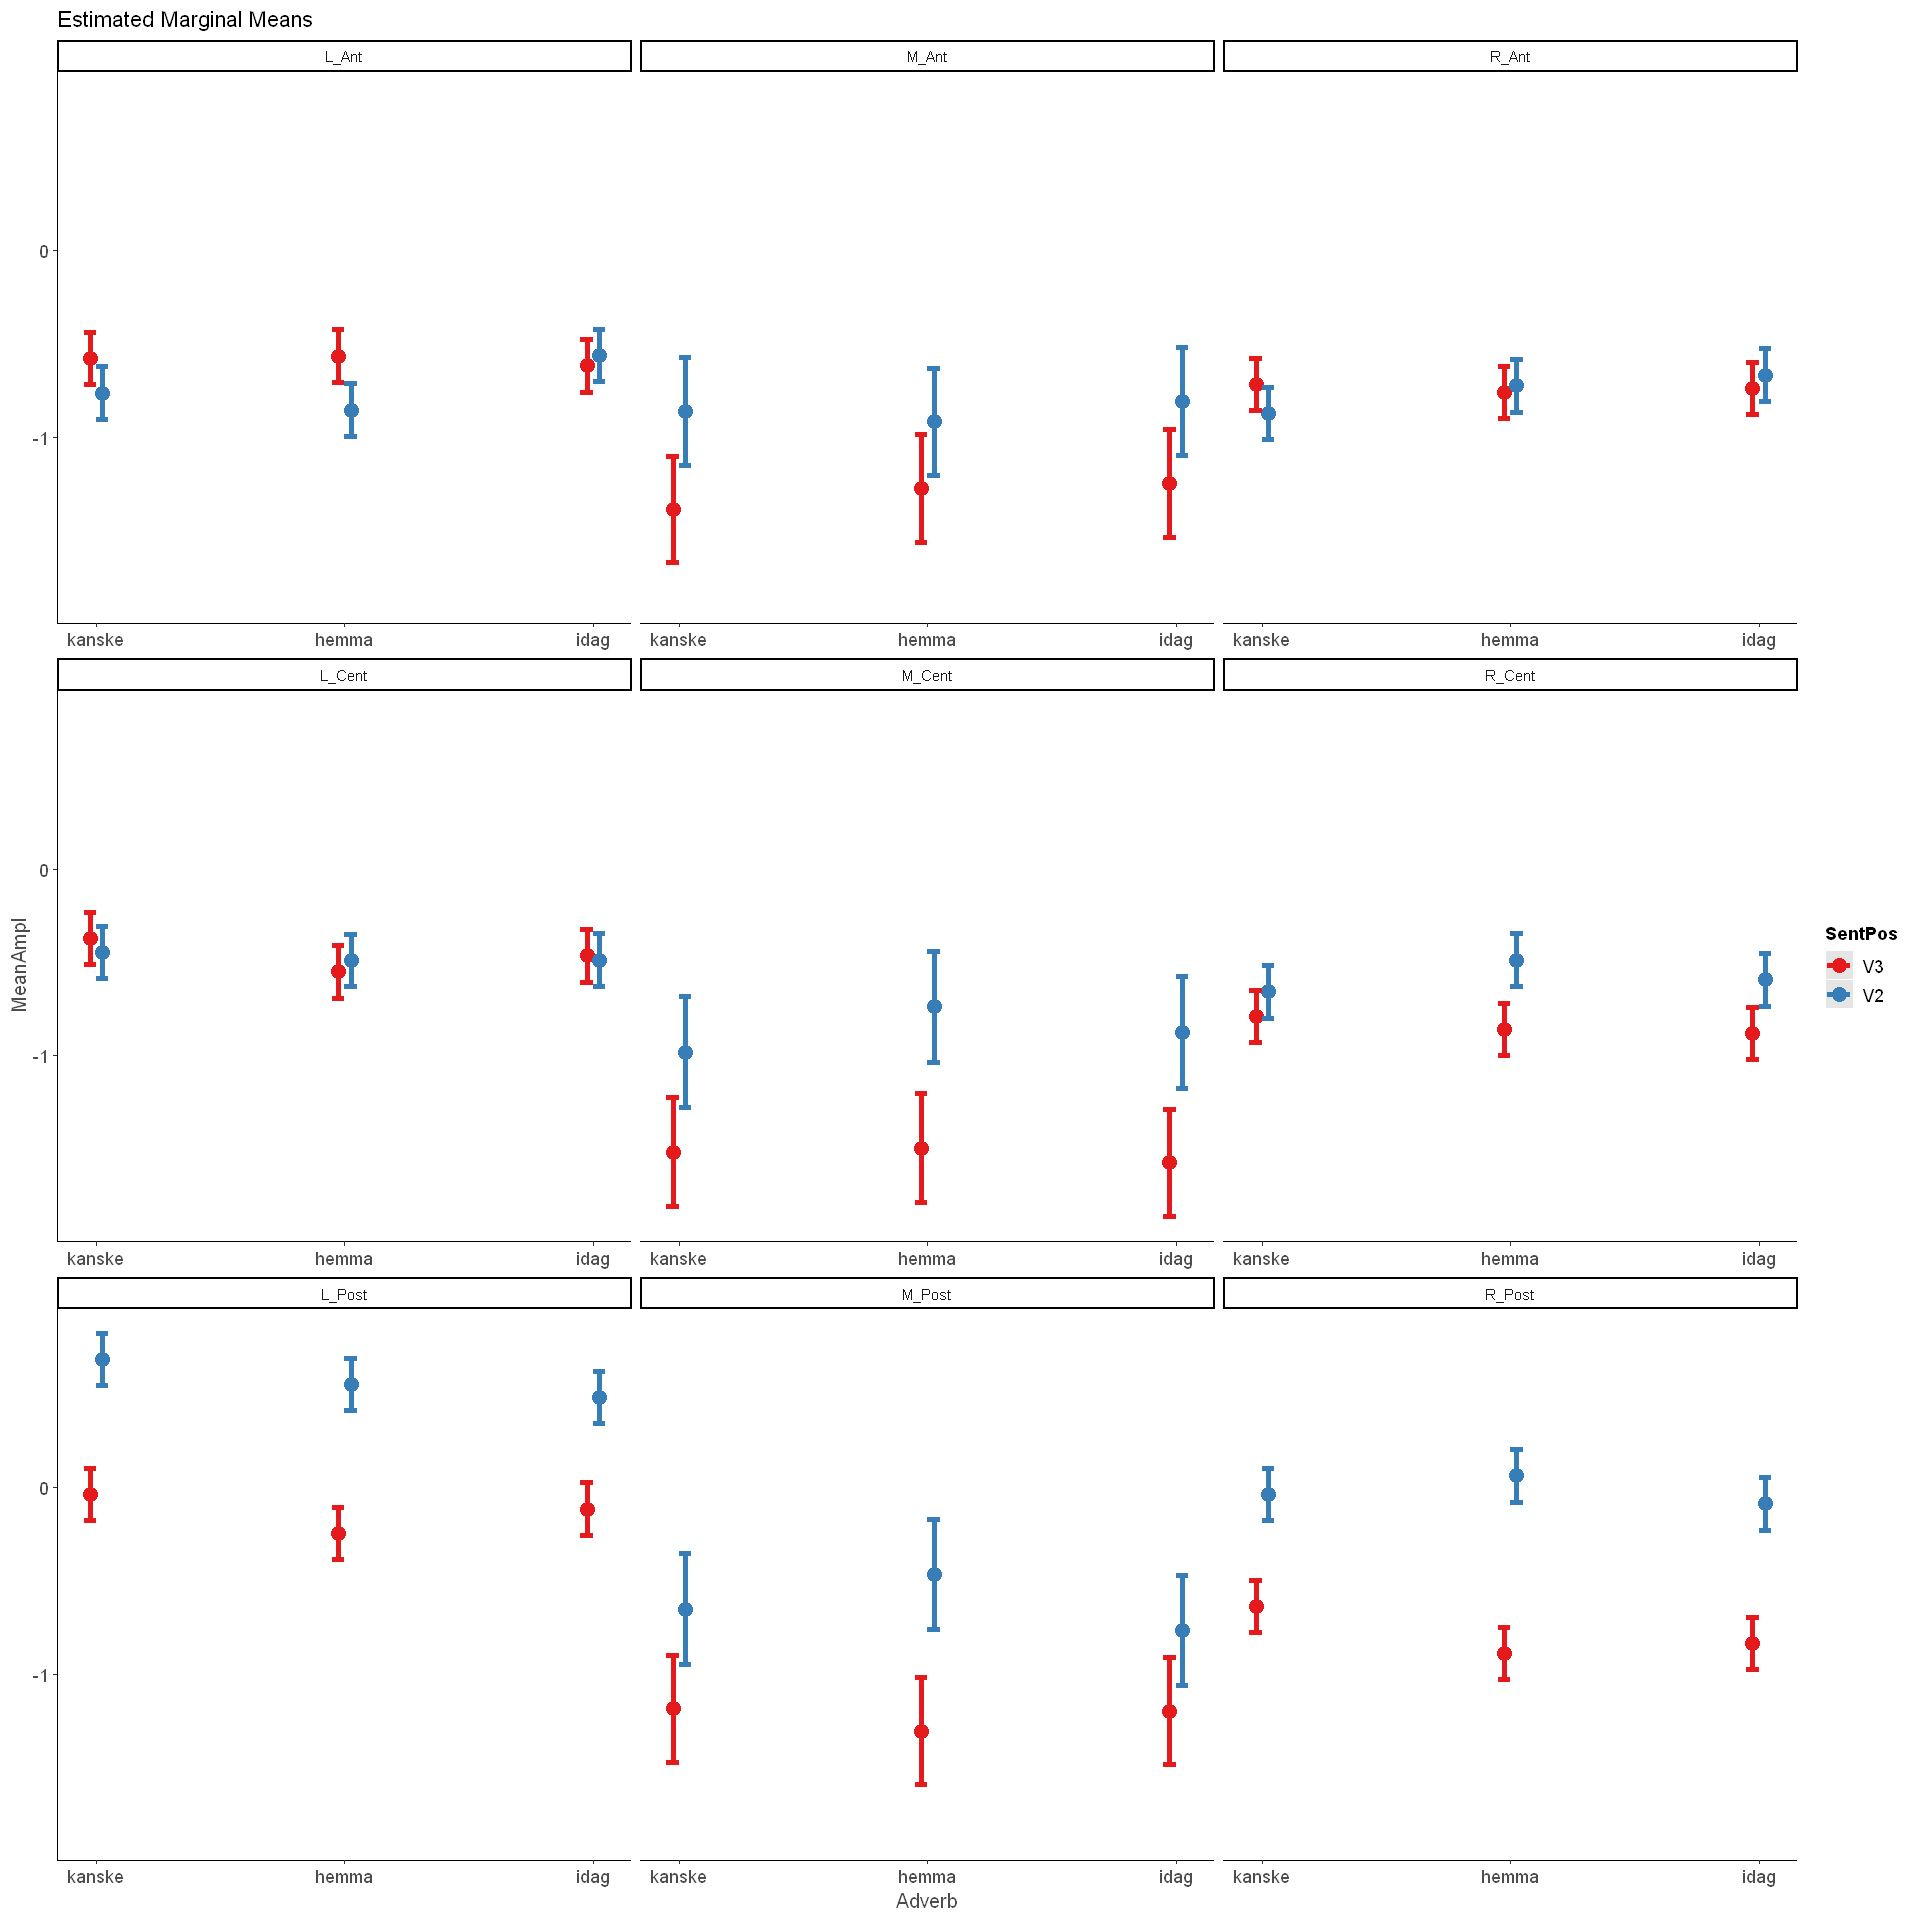

In [92]:
# save PDF
pdf(paste('../figures/', 'lme_model_plot_', component, '.pdf', sep="")) 
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )
dev.off() 

# plot in this notebook
options(repr.plot.width=16, repr.plot.height=16)
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )

In [81]:
date()

[1] "Sat Aug 28 19:40:28 2021"